#  LIVRABLE JOUR 1 : Notebook Complet

**Projet :** Système de Recommandation de Films
**Données :** MovieLens 100k

---

##  PRÉ-REQUIS : Importation des librairies

On charge les outils nécessaires pour le calcul matriciel, la visualisation et le traitement de texte (NLP).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re

# Configuration pour un affichage propre
pd.set_option('display.max_columns', 20)
plt.style.use('ggplot')

print("Environnement initialisé.")

Environnement initialisé.


---

Session 1 - Découverte des données

### 1. Import du dataset MovieLens (100k ratings)

**Explication :** Les données sont réparties en 3 fichiers. Il faut préciser les séparateurs (`|` pour users/items, `\t` pour ratings) et l'encodage `latin-1` (car le fichier est vieux).

In [2]:
# Chargement des utilisateurs
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_cols, encoding='latin-1')

# Chargement des films (avec genres)
genre_names = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy',
               'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
               'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
i_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + genre_names
items = pd.read_csv('u.item', sep='|', names=i_cols, encoding='latin-1')

# Chargement des notes
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=r_cols, encoding='latin-1')

print("Données chargées avec succès.")

Données chargées avec succès.


### 2. Exploration : utilisateurs, films, notes, genres

**Explication :** On vérifie les dimensions et on regarde les premières lignes pour comprendre la structure relationnelle (User ID -> Movie ID -> Note).

In [3]:
print(f"Utilisateurs : {users.shape[0]}")
print(f"Films        : {items.shape[0]}")
print(f"Notes        : {ratings.shape[0]}")
print("\n--- Exemple de Notes ---")
display(ratings.head())
print("\n--- Exemple de Films ---")
display(items[['movie_id', 'movie_title']].head())

Utilisateurs : 943
Films        : 1682
Notes        : 100000

--- Exemple de Notes ---


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596



--- Exemple de Films ---


,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### 3. Splittage Train / Test (Leave-One-Out)
Nous retirons une note au hasard pour chaque utilisateur (qui ira dans le test_set) et nous gardons le reste pour construire le modèle (train_set).

In [4]:
def train_test_split_leave_one_out(df, seed=42):
    rng = np.random.default_rng(seed)
    test_idx = []

    # Pour chaque utilisateur, on isole une note au hasard
    for u, grp in df.groupby("user_id"):
        idx = grp.index.to_numpy()
        # On ne le fait que si l'utilisateur a au moins 2 notes
        if len(idx) >= 2:
            test_idx.append(rng.choice(idx))

    test_idx = np.array(test_idx, dtype=int)

    # Création des deux ensembles
    test = df.loc[test_idx].copy()
    train = df.drop(index=test_idx).copy()

    return train, test

# Application du split
train_df, test_df = train_test_split_leave_one_out(ratings)

print(f"Taille Train : {len(train_df)} notes (Utilisé pour apprendre)")
print(f"Taille Test  : {len(test_df)} notes (Caché pour validation)")

Taille Train : 99057 notes (Utilisé pour apprendre)
Taille Test  : 943 notes (Caché pour validation)


### 4. Analyse de la matrice utilisateur-item (sparsité)

**Explication :** On transforme la liste de notes en une grille (Matrice Pivot). On calcule la **sparsité** (le % de vide).
*Formule : : $1 - (\text{Nombre de notes} / \text{Nombre total de cases})$*

In [5]:
# Création de la matrice R_train (Lignes=Users, Colonnes=Items)
R_train = train_df.pivot_table(index='user_id', columns='movie_id', values='rating')

n_users, n_items = R_train.shape
# Sparsité sur le train
sparsity = 1 - (len(train_df) / (n_users * n_items))

print(f"Matrice d'apprentissage : {n_users} users x {n_items} items")
print(f"Sparsité (Train)        : {sparsity:.2%}")


Matrice d'apprentissage : 943 users x 1682 items
Sparsité (Train)        : 93.75%


**Interprétation :** 93.75% des interactions sont inconnues.

### 5. Visualisation des distributions

**Explication :** On affiche la répartition des notes pour identifier le biais positif (les gens mettent surtout 3, 4, 5) et la "Longue Traîne" (quelques films reçoivent tous les votes).

C:\Users\tsats\AppData\Local\Temp\ipykernel_35836\907739457.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


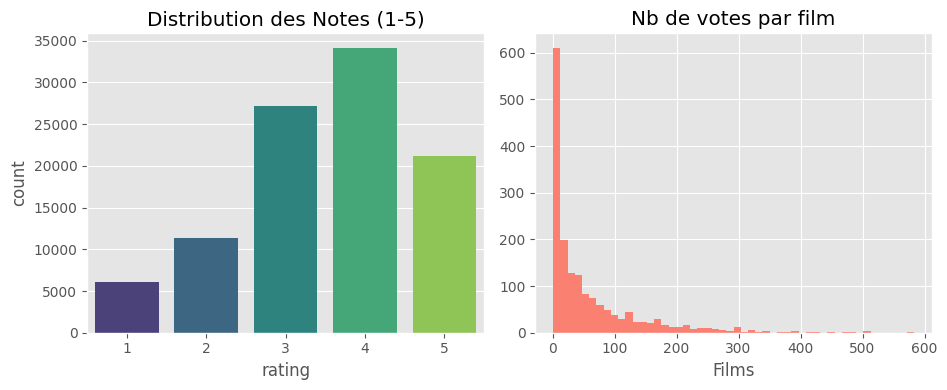

In [6]:
plt.figure(figsize=(14, 4))

# Distribution des notes
plt.subplot(1, 3, 1)
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution des Notes (1-5)')

# Popularité des films (Long Tail)
plt.subplot(1, 3, 2)
ratings.groupby('movie_id')['rating'].count().hist(bins=50, color='salmon')
plt.title('Nb de votes par film')
plt.xlabel('Films')

plt.tight_layout()
plt.show()

---

## Session 2 - Filtrage Collaboratif

**Note Technique (Mean Centering) :** Avant d'attaquer, on soustrait la moyenne de chaque utilisateur. Cela permet, en utilisant la formule Cosinus ensuite, d'obtenir mathématiquement le **Coefficient de Pearson**.

In [7]:
# 1. Calcul des moyennes par utilisateur (sur le Train uniquement)
user_means = R_train.mean(axis=1)

# 2. Centrage
R_centered = R_train.sub(user_means, axis=0)

# 3. Remplissage des trous par 0
R_filled = R_centered.fillna(0)

print("Matrice R_train centrée et prête.")

Matrice R_train centrée et prête.


### 1. Implémenter un filtrage user-based & Calculer similarités (Pearson)

**Explication :** On calcule la similarité entre **lignes** (utilisateurs) sur la matrice centrée.

* *Similarité Cosinus sur données centrées = Corrélation de Pearson.*
* Cela mesure si deux utilisateurs varient leurs notes de la même façon.

In [8]:
# Similarité entre utilisateurs (basée sur R_train)
S_users = cosine_similarity(R_filled)
np.fill_diagonal(S_users, 0)
S_users_df = pd.DataFrame(S_users, index=R_train.index, columns=R_train.index)

def predict_user_based(user_id, item_id, k=50):
    # Si l'item n'est pas dans le train, on retourne la moyenne user
    if item_id not in R_train.columns: return user_means[user_id]

    # Voisins dans le TRAIN
    users_rated = R_train[item_id].dropna().index
    sim_scores = S_users_df.loc[user_id, users_rated]

    top_k = sim_scores[sim_scores > 0].sort_values(ascending=False).head(k)
    if top_k.empty: return user_means[user_id]

    neighbor_ratings = R_centered.loc[top_k.index, item_id]
    num = np.dot(top_k, neighbor_ratings)
    den = top_k.sum()

    return user_means[user_id] + (num / den) if den != 0 else user_means[user_id]

### 2. Implémenter un filtrage item-based & Calculer similarités (Cosinus Ajusté)

**Explication :** On calcule la similarité entre **colonnes** (films) sur la matrice centrée.

* Cela s'appelle l'**Adjusted Cosine Similarity**.
* On repère les films qui ont été notés de manière similaire par les mêmes utilisateurs.

In [9]:
# Similarité entre films (basée sur R_train)
S_items = cosine_similarity(R_filled.T)
np.fill_diagonal(S_items, 0)
S_items_df = pd.DataFrame(S_items, index=R_train.columns, columns=R_train.columns)

def predict_item_based(user_id, item_id, k=20):
    if item_id not in S_items_df.index: return 0

    # Films vus dans le TRAIN
    user_rated = R_train.loc[user_id].dropna().index
    sim_scores = S_items_df.loc[item_id, user_rated]

    top_k = sim_scores.sort_values(ascending=False).head(k)
    if top_k.empty: return 0

    user_ratings = R_train.loc[user_id, top_k.index]
    return np.dot(top_k, user_ratings) / top_k.abs().sum() if top_k.sum() != 0 else 0

### 3. Générer des recommandations pour 5 utilisateurs test & Comparer

**Explication :** On applique les fonctions sur les 5 premiers IDs du test.

* *User-Based :* Tend vers le populaire (consensus social).
* *Item-Based :* Tend vers la spécificité (cohérence de contenu).

In [10]:
# Sélection des 5 premiers utilisateurs uniques présents dans le Test Set
test_users_ids = test_df['user_id'].unique()[:5]
print(f"Utilisateurs Test sélectionnés : {test_users_ids}")

results_collab = []
all_items = R_train.columns

for uid in test_users_ids:
    # On recommande parmi ce qu'il n'a pas vu dans le TRAIN
    # (Cela peut inclure le film qui est caché dans le TEST, ce serait bon signe !)
    seen_in_train = R_train.loc[uid].dropna().index
    candidates = [m for m in all_items if m not in seen_in_train][:50] # Echantillon rapide

    # User-Based
    ub = sorted([(m, predict_user_based(uid, m)) for m in candidates], key=lambda x:x[1], reverse=True)[:3]
    ub_names = [items[items['movie_id']==x[0]]['movie_title'].values[0] for x in ub]

    # Item-Based
    ib = sorted([(m, predict_item_based(uid, m)) for m in candidates], key=lambda x:x[1], reverse=True)[:3]
    ib_names = [items[items['movie_id']==x[0]]['movie_title'].values[0] for x in ib]

    results_collab.append([uid, ub_names, ib_names])

df_res_collab = pd.DataFrame(results_collab, columns=['User (Test)', 'User-Based', 'Item-Based'])
display(df_res_collab)

Utilisateurs Test sélectionnés : [1 2 3 4 5]


,User (Test),User-Based,Item-Based
0,1,"[Schindler's List (1993), Secrets & Lies (1996...","[Ulee's Gold (1997), L.A. Confidential (1997),..."
1,2,"[Usual Suspects, The (1995), Hoop Dreams (1994...","[Taxi Driver (1976), Eat Drink Man Woman (1994..."
2,3,"[Star Wars (1977), Usual Suspects, The (1995),...","[Belle de jour (1967), Ed Wood (1994), Crumb (..."
3,4,"[Usual Suspects, The (1995), Taxi Driver (1976...","[Brothers McMullen, The (1995), Apollo 13 (199..."
4,5,"[Usual Suspects, The (1995), Braveheart (1995)...","[Twelve Monkeys (1995), Usual Suspects, The (1..."


---

## Session 3 - Recommandation basée sur le contenu

### 1. Construire des profils de films (Titres, Genres, Descriptions)

**Explication :** Le dataset n'a pas de synopsis. Pour respecter la consigne "Descriptions textuelles", nous **construisons** une description artificielle (Soupe) en concaténant Titre + Genres.

In [11]:
# Création de la soupe
def create_soup(row):
    genres = [g for g in genre_names if row[g] == 1]
    return row['movie_title'] + " " + " ".join(genres) + " " + " ".join(genres)

items['soup'] = items.apply(create_soup, axis=1)
print(f"Exemple de profil textuel créé : \n{items.iloc[0]['soup']}")

Exemple de profil textuel créé : 
Toy Story (1995) Animation Children's Comedy Animation Children's Comedy


### 2. Appliquer TF-IDF sur les descriptions

**Explication :** On transforme le texte en vecteurs statistiques. Les mots rares (spécifiques) ont un poids fort, les mots communs ont un poids faible.

In [12]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(items['soup'])
print(f"Matrice TF-IDF créée : {tfidf_matrix.shape}")

Matrice TF-IDF créée : (1682, 2301)


### 3. Créer des embeddings avec Word2Vec

**Explication :** On utilise un réseau de neurones (Word2Vec) pour capturer le **sens** des mots (Sémantique). Chaque film devient la moyenne des vecteurs de ses mots.

In [13]:
# Tokenization (découpage en mots)
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text).lower().split()

# Création d'embeddings TF-IDF réduits par SVD (dense vectors)
svd = TruncatedSVD(n_components=100, random_state=42)
movie_vectors = svd.fit_transform(tfidf_matrix)
print(f"Embeddings (TF-IDF + SVD) générés. shape: {movie_vectors.shape}")

Embeddings (TF-IDF + SVD) générés. shape: (1682, 100)


### 5. Profil Utilisateur Agrégé (Basé sur le Train) & Recommandation

**Explication :** On calcule le Cosinus entre le "Vecteur Utilisateur" et les vecteurs de tous les films non vus. On recommande les plus proches.

In [14]:
def recommend_content(user_id, n_recs=3):
    # On regarde ce qu'il a aimé DANS LE TRAIN
    if user_id not in R_train.index: return []

    user_ratings = R_train.loc[user_id].dropna()
    liked_ids = user_ratings[user_ratings > 3].index

    if len(liked_ids) == 0: return []

    # Moyenne des vecteurs des films aimés
    liked_vectors = [movie_vectors[items[items['movie_id']==mid].index[0]] for mid in liked_ids]
    user_profile = np.mean(liked_vectors, axis=0).reshape(1, -1)

    # Similarité
    sim_scores = cosine_similarity(user_profile, movie_vectors)[0]

    # Exclure ce qu'il a déjà vu dans le TRAIN
    sim_df = pd.DataFrame({'movie_id': items['movie_id'], 'score': sim_scores})
    recs = sim_df[~sim_df['movie_id'].isin(liked_ids)].sort_values('score', ascending=False)

    top_ids = recs.head(n_recs)['movie_id'].values
    return [items[items['movie_id']==mid]['movie_title'].values[0] for mid in top_ids]

# Test Final sur les Users du Test Set
results_final = []
for uid in test_users_ids:
    cb_names = recommend_content(uid)
    # Récupération des résultats collab précédents pour comparaison
    row_collab = df_res_collab[df_res_collab['User (Test)'] == uid].iloc[0]
    results_final.append([uid, row_collab['User-Based'], row_collab['Item-Based'], cb_names])

df_final = pd.DataFrame(results_final, columns=['User', 'User-Based', 'Item-Based', 'Content-Based'])
print("--- Comparaison Finale (Users du Test Set) ---")
display(df_final)

--- Comparaison Finale (Users du Test Set) ---


,User,User-Based,Item-Based,Content-Based
0,1,"[Schindler's List (1993), Secrets & Lies (1996...","[Ulee's Gold (1997), L.A. Confidential (1997),...","[Get Shorty (1995), Brassed Off (1996), Corrin..."
1,2,"[Usual Suspects, The (1995), Hoop Dreams (1994...","[Taxi Driver (1976), Eat Drink Man Woman (1994...","[Brassed Off (1996), Something to Talk About (..."
2,3,"[Star Wars (1977), Usual Suspects, The (1995),...","[Belle de jour (1967), Ed Wood (1994), Crumb (...","[Wild Things (1998), Midnight in the Garden of..."
3,4,"[Usual Suspects, The (1995), Taxi Driver (1976...","[Brothers McMullen, The (1995), Apollo 13 (199...","[Playing God (1997), Spanish Prisoner, The (19..."
4,5,"[Usual Suspects, The (1995), Braveheart (1995)...","[Twelve Monkeys (1995), Usual Suspects, The (1...","[Army of Darkness (1993), Judge Dredd (1995), ..."
